In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import librosa
import scipy.stats


In [ ]:
# Load data
df = pd.read_csv('voice.csv')

df.head()


In [2]:
df.info()

NameError: name 'df' is not defined

In [5]:
x = df[['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'sp.ent', 'sfm', 'mode','centroid', 'meanfun',
         'minfun', 'maxfun', 'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx']].values
y = df['label'].values



In [11]:
df.shape

(3168, 21)

<Axes: xlabel='label'>

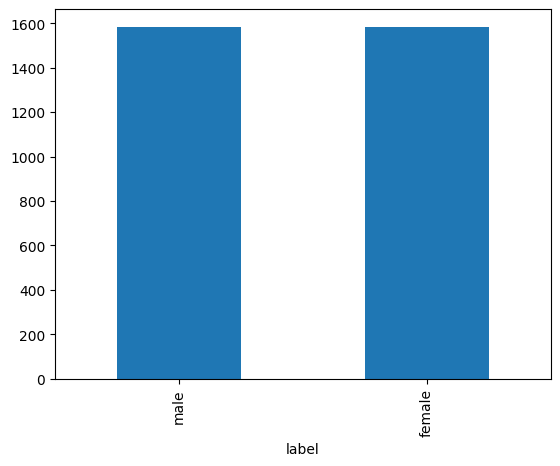

In [6]:
df['label'].value_counts().plot(kind='bar')

In [7]:
# Correct label replacement (remove trailing space)
df['label'].replace(['female', 'male'], [0, 1], inplace=True)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=15)


In [8]:
xtrain = np.asarray(xtrain).astype(np.float32)
ytrain = np.asarray(ytrain).astype(np.float32)
xtest = np.asarray(xtest).astype(np.float32)
ytest = np.asarray(ytest).astype(np.float32)

In [9]:
# Build the model
inputs = keras.Input(shape=(20))
x = layers.Dense(10, activation="sigmoid")(inputs) #(20 + 1)*(10)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# Model summary
model.summary()

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
train = model.fit(xtrain,ytrain,validation_data=(xtest,ytest), epochs=100,verbose=1)
model.evaluate(xtest,ytest)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 batch_normalization (Batch  (None, 10)                40        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 261 (1.02 KB)
Trainable params: 241 (964.00 Byte)
Non-trainable params: 20 (80.00 Byte)
_________________________________________________________________
Epoch 1/100
80/80 [==============================] - 2s 6ms/step - loss: 0.7568 - accuracy:

[0.09860359132289886, 0.9668769836425781]

20/20 [==============================] - 0s 2ms/step


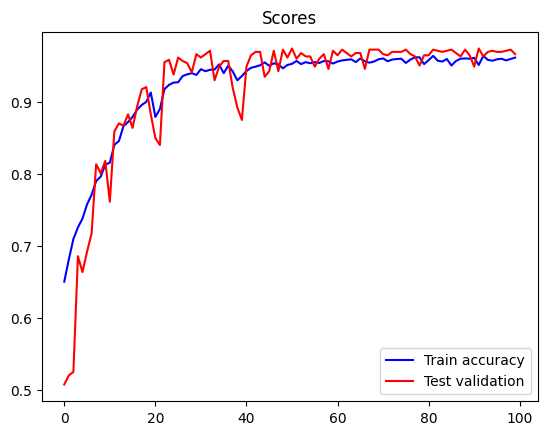

In [10]:

def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Train accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Test validation')
    # plt.hlines(0.95,0,50)
    plt.title('Scores')
    plt.legend()
    plt.show()

plot_scores(train)


In [11]:
model.save('ML.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy.stats
import librosa
import numpy as np

def extract_features(audio_path):
    y, sr = librosa.load(audio_path)
    S = np.abs(librosa.stft(y))
    centroid = librosa.feature.spectral_centroid(S=S)[0]

    features = {}

    features['meanfreq'] = np.mean(centroid) / 1000
    features['sd'] = np.std(centroid) / 1000
    features['median'] = np.median(centroid) / 1000
    features['Q25'] = np.percentile(centroid, 25) / 1000
    features['Q75'] = np.percentile(centroid, 75) / 1000
    features['IQR'] = features['Q75'] - features['Q25']
    features['skew'] = scipy.stats.skew(centroid)
    features['kurt'] = scipy.stats.kurtosis(centroid)
    features['sp.ent'] = scipy.stats.entropy(S.flatten())
    features['sfm'] = np.mean(librosa.feature.spectral_flatness(S=S))

    mode_result = scipy.stats.mode(centroid)
    mode_value = np.atleast_1d(mode_result.mode)[0]
    features['mode'] = mode_value / 1000

    features['centroid'] = np.mean(centroid) / 1000


    yin_values = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    features['meanfun'] = np.mean(yin_values) / 1000
    features['minfun'] = np.min(yin_values) / 1000
    features['maxfun'] = np.max(yin_values) / 1000

    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    features['meandom'] = np.mean(tonnetz)
    features['mindom'] = np.min(tonnetz)
    features['maxdom'] = np.max(tonnetz)
    features['dfrange'] = features['maxdom'] - features['mindom']
    features['modindx'] = np.mean(np.abs(np.diff(yin_values))) / (features['maxfun'] - features['minfun'])

    return features

audio = '/content/girl.mpga'

f = extract_features(audio)

In [14]:
import tensorflow as tf

In [15]:
model = tf.keras.models.load_model('ML.h5')

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 batch_normalization (Batch  (None, 10)                40        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 261 (1.02 KB)
Trainable params: 241 (964.00 Byte)
Non-trainable params: 20 (80.00 Byte)
_________________________________________________________________


In [18]:
key = ['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun',
         'minfun', 'maxfun', 'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx']
data = []
for i in key:
  data.append(f[i])
 

0.6538670203901099
1.3650264082363706
0.0
0.0
0.5602073376021549
0.5602073376021549
2.6090725726631727
6.5149287431774106
8.230271
0.68396854
0.0
0.6538670203901099
1.6382156726687083
0.06523668639053254
2.205
0.0004798874430862082
-0.3149681202161071
0.4467667341232298
0.761734854339337
21.248333969985506


In [37]:
xtest.shape

(634, 20)

In [21]:
data = np.array(data)
data.shape

(20,)

In [22]:
data = data.reshape((1,20))

In [23]:
model.evaluate(xtest,ytest)

20/20 [==============================] - 0s 2ms/step - loss: 0.0986 - accuracy: 0.9669


[0.09860359132289886, 0.9668769836425781]

In [24]:

pre = model.predict(data)
pre

1/1 [==============================] - 0s 71ms/step


array([[0.00045873]], dtype=float32)

In [26]:
import IPython.display as ipd

In [27]:
ipd.Audio(audio)